In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ExpSineSquared, ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [34]:
# train the model using the Randomized Search
def trainModel(model, param_distributions, X_trn, y_trn, data_name, **kwargs):
    clf = model(**kwargs)
    print('Trainning', clf.__class__.__name__ ,'classifier model with ' , data_name , 'data...')
    
    #use standard scaler to scale the data
    scaler = sklearn.preprocessing.StandardScaler()
    X_trn = scaler.fit_transform(X_trn)
    
    search = sklearn.model_selection.RandomizedSearchCV(clf, param_distributions)
    search.fit(X_trn, y_trn)
    best_param = search.best_params_
    print('using' , search.best_estimator_)
    clf = model(**kwargs)
    clf.set_params(**best_param)
    clf.fit(X_trn, y_trn)
    return clf

# train the model using the Grid Search
def trainModelGridSearch(model, param_distributions, X_trn, y_trn, data_name, **kwargs):
    clf = model(**kwargs)
    print('Trainning', clf.__class__.__name__ ,'classifier model with ' , data_name , 'data...')
    
    #use standard scaler to scale the data
    scaler = sklearn.preprocessing.StandardScaler()
    X_trn = scaler.fit_transform(X_trn)
    
    search = sklearn.model_selection.GridSearchCV(clf, param_distributions)
    search.fit(X_trn, y_trn)
    best_param = search.best_params_
    print('using' , search.best_estimator_)
    clf = model(**kwargs)
    clf.set_params(**best_param)
    clf.fit(X_trn, y_trn)
    return clf

# compute the score of the input estimator
def computeScore(estimator, X_test, y_test, data_name):
    scaler = sklearn.preprocessing.StandardScaler()
    X_test = scaler.fit_transform(X_test)
    score = round(estimator.score(X_test, y_test), 2 )* 100
    print('testing accuracy using ', estimator.__class__.__name__, 'for data', data_name , score, '%')
    print()
    return score

def separateData(X,y):
    X_trn, X_tst, y_trn, y_tst = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=0)
    return X_trn, X_tst, y_trn, y_tst

In [195]:
# Train all the classifiers with different 
def train_with_all_classifier(X_trn, y_trn, data_name, X_tst, y_tst):
    import warnings
    warnings.filterwarnings("ignore")
    estimators = []
    scores = []
    
    #Linear Regression
    logistic_estimator = sklearn.linear_model.LinearRegression()
    print('Training Linear regression model with ' , data_name , 'dataset')
    logistic_estimator.fit(X_trn,y_trn)
    estimators.append(logistic_estimator)
    scores.append(computeScore(logistic_estimator, X_tst, y_tst, data_name))
    
    #SVM
    param_distributions = {
        'C' : [0.01,0.1,1.0],
        'gamma' : [0.1,0.5,2.0]
    }
    
    svr_estimator = trainModelGridSearch(sklearn.svm.SVR, param_distributions, X_trn, 
                                         y_trn, data_name, max_iter = 1)
    estimators.append(svr_estimator)
    scores.append(computeScore(svr_estimator, X_tst, y_tst, data_name))

    
    #Decision Tree Classifier
    param_distributions = {
            'criterion' : ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
            'max_depth' : [2,4,6,10,20]
    }
    decision_tree_estimator = trainModel(sklearn.tree.DecisionTreeRegressor, param_distributions, X_trn, 
                                         y_trn, data_name)
    estimators.append(decision_tree_estimator)
    scores.append(computeScore(decision_tree_estimator, X_tst, y_tst, data_name))
    
    #Random Forest Classifier
    param_distributions = {
            'n_estimators' : [50,100,200,300],
            'max_depth' : [1,2,4]
    }
    randomForest_estimator = trainModel(sklearn.ensemble.RandomForestRegressor, param_distributions, X_trn, 
                                         y_trn, data_name)
    estimators.append(randomForest_estimator)
    scores.append(computeScore(randomForest_estimator, X_tst, y_tst, data_name))
    
    #KNeighborsRegressor
    param_distributions = {
            'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'n_neighbors' : [5,10,20]
    }
    kneighbours_estimator = trainModel(sklearn.neighbors.KNeighborsRegressor, param_distributions, X_trn, 
                                         y_trn, data_name)
    estimators.append(kneighbours_estimator)
    scores.append(computeScore(kneighbours_estimator, X_tst, y_tst, data_name))
    
    #Adaboost
    param_distributions = {
            'n_estimators' : [10, 30, 50,100],
            'learning_rate' : [0.2,1.0,1.2,2.0]
    }
    Adaboost_estimator = trainModel(sklearn.ensemble.AdaBoostRegressor, param_distributions, X_trn, 
                                         y_trn, data_name, random_state=0)
    estimators.append(Adaboost_estimator)
    scores.append(computeScore(Adaboost_estimator, X_tst, y_tst, data_name))
    
    
    #GaussianProcessRegressor
    param_distributions = {
            'alpha' : [0.00000001,0.001,1,10,100],
            'n_restarts_optimizer' : [0,1,2,3]
    }
    Gaussian_estimator = trainModel(sklearn.gaussian_process.GaussianProcessRegressor, param_distributions, X_trn, 
                                         y_trn, data_name, random_state=0)
    estimators.append(Gaussian_estimator)
    scores.append(computeScore(Gaussian_estimator, X_tst, y_tst, data_name))

    
    #neural_network MLPRegressor
    param_distributions = {
            'hidden_layer_sizes' : [5,10,50,100],
            'learning_rate' : ['constant', 'invscaling', 'adaptive']
    }
    Neural_estimator = trainModel(sklearn.neural_network.MLPRegressor, param_distributions, X_trn, 
                                         y_trn, data_name, max_iter = 10, random_state=0)
    estimators.append(Neural_estimator)
    scores.append(computeScore(Neural_estimator, X_tst, y_tst, data_name))
    print('---------------------------------------------------')
    return estimators, scores


In [187]:
def plotBarGraph(score_list, title):
    classifier_list = ['LogisticRegression', 'SVC', 'DecisionTreeClassifier','RandomForestClassifier','KNeighborsRegressor',
                   'AdaBoostClassifier', 'GaussianProcessRegressor','MLPRegressor']
    # x-coordinates of left sides of bars
    left = []
    scores = []
    # labels for bars
    #tick_label = classifier_list
    tick_label = []
    plt.figure(figsize=(18,5))
    plt.grid(zorder=0)
    
    plt.title(title)
    for i in range(len(score_list)):
        if score_list[i] < -10:
            scores.append(0)
        else:
            scores.append(score_list[i])
        left.append(i+1)
        tick_label.append(classifier_list[i])
            
    plt.bar(left, scores, tick_label = tick_label,
            width = 0.2, color = ['red', 'green'])
   # print(scores)
    best_score = max(scores)
    plt.text(6, 60, 'best accuracy estimator = ' + classifier_list[score_list.index(best_score)] + ' score: '+ str(best_score) + ' %' , fontsize=15, color = 'brown')

# =====================Dataset 1. Wines==========================
Since we have white and red wine, let us initialize a new row: color in which it is equal to 1 when the wine is a white wine, 0 if it is red.

In [35]:
# Extracting the data

whiteWine = pd.read_csv('resources2/winequality-white.csv',sep=';')
redWine = pd.read_csv('resources2/winequality-red.csv',sep=';')
color =[]
# 0 is for white color and 1 is for red color
for i in range(len(whiteWine)):
    color.append(0)
for j in range(len(redWine)):
    color.append(1)


bothWines = pd.concat([whiteWine, redWine], axis=0)
bothWines['color'] = color

X = bothWines.drop('quality', axis='columns')
y = bothWines['quality']


X_trn_wine,X_tst_wine,y_trn_wine,y_tst_wine = train_test_split(wx,wy,random_state=0,stratify=wy)

display(bothWines)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,0
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,0
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,0
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,1


In [47]:
%%time
wine_estimators, wine_scores = train_with_all_classifier(X_trn_wine, y_trn_wine,
                                                                 'Wine', X_tst_wine,y_tst_wine)


Trainning LogisticRegression classifier model with  Wine data...
using LogisticRegression(C=100, max_iter=10, random_state=0)
testing accuracy using  LogisticRegression for data Wine 97.0 %

Trainning SVC classifier model with  Wine data...
using SVC(gamma=0.1, max_iter=10, random_state=0)
testing accuracy using  SVC for data Wine 88.0 %

Trainning DecisionTreeClassifier classifier model with  Wine data...
using DecisionTreeClassifier(max_depth=4, random_state=0)
testing accuracy using  DecisionTreeClassifier for data Wine 100.0 %

Trainning RandomForestClassifier classifier model with  Wine data...
using RandomForestClassifier(max_depth=10, n_estimators=400, random_state=0)
testing accuracy using  RandomForestClassifier for data Wine 100.0 %

Trainning KNeighborsRegressor classifier model with  Wine data...
using KNeighborsRegressor(algorithm='brute')
testing accuracy using  KNeighborsRegressor for data Wine 96.0 %

Trainning AdaBoostClassifier classifier model with  Wine data...
usin

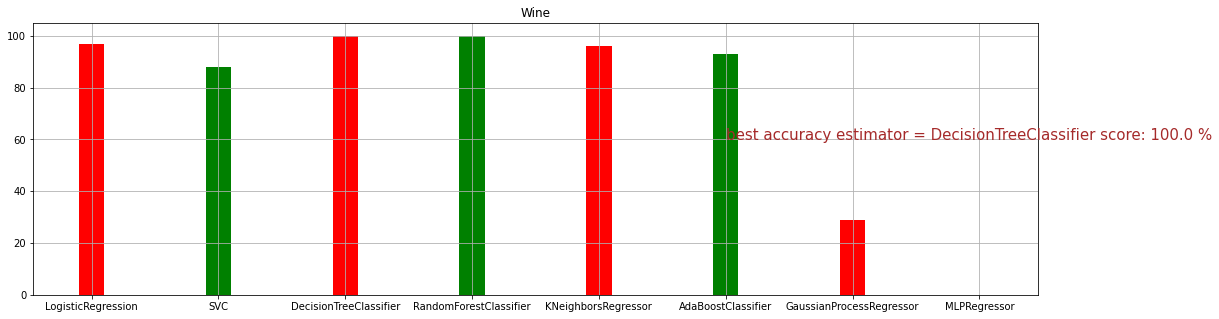

In [179]:
plotBarGraph(wine_scores, 'Wine')

# ===============Dataset 2. Communities and Crimes===============

In [52]:
data = pd.read_csv('resources2/communities.data',sep=',',header=None, skipinitialspace=True)
# encode by converting to int
print('before encoding')
display(data)
for i in range(0, 128):
    data[i] = encoder.fit_transform(data[i])

X = data.drop(127, axis='columns')
y = data[127]

print('after encoding')
display(data)
X_trn_crime, X_tst_crime, y_trn_crime, y_tst_crime = separateData(X,y)

before encoding


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


after encoding


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,5,108,799,804,0,19,28,2,88,12,...,12,26,20,6,4,62,1,17,14,20
1,42,108,799,1625,0,0,11,12,72,45,...,2,12,45,63,38,72,3,0,51,67
2,18,108,799,1,0,0,37,49,54,17,...,1,21,2,63,38,72,3,0,51,43
3,25,56,725,1787,0,4,71,99,6,12,...,2,39,28,63,38,72,3,0,51,12
4,33,105,517,141,0,1,50,2,93,9,...,4,9,2,63,38,72,3,0,51,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,9,108,799,1597,9,1,35,10,85,12,...,1,28,5,63,38,72,3,0,51,9
1990,4,108,799,1455,9,5,88,46,26,78,...,2,37,20,63,38,72,3,0,51,45
1991,6,102,709,1707,9,16,32,25,67,4,...,8,32,18,8,6,50,0,73,28,23
1992,19,34,621,1695,9,8,46,6,85,22,...,3,38,33,2,2,51,0,7,18,19


In [53]:
%%time
crime_estimators, crime_scores = train_with_all_classifier(X_trn_crime, y_trn_crime,
                                                                 'Communities and Crimes', X_tst_crime,y_tst_crime)

Trainning LogisticRegression classifier model with  Communities and Crimes data...
using LogisticRegression(C=0.01, max_iter=10, random_state=0)
testing accuracy using  LogisticRegression for data Communities and Crimes 10.0 %

Trainning SVC classifier model with  Communities and Crimes data...
using SVC(C=0.1, gamma=0.1, max_iter=10, random_state=0)
testing accuracy using  SVC for data Communities and Crimes 6.0 %

Trainning DecisionTreeClassifier classifier model with  Communities and Crimes data...
using DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)
testing accuracy using  DecisionTreeClassifier for data Communities and Crimes 6.0 %

Trainning RandomForestClassifier classifier model with  Communities and Crimes data...
using RandomForestClassifier(max_depth=4, random_state=0)
testing accuracy using  RandomForestClassifier for data Communities and Crimes 12.0 %

Trainning KNeighborsRegressor classifier model with  Communities and Crimes data...
using KNeigh

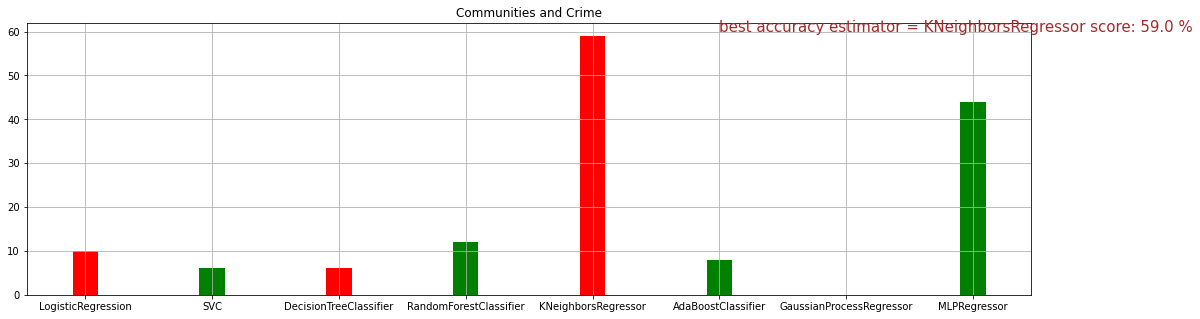

In [180]:
plotBarGraph(crime_scores, 'Communities and Crime')

# ======================Dataset 3.  =========================

In [126]:
#Preparing data for traing
#getting the default dataset
#aquaticToxicity
#since the data does not have label, so using the data description we have to label the data 
aquaticToxicity = pd.read_csv('resources2/qsar_aquatic_toxicity.csv',sep=';',names=["TPSA(Tot)","SAacc","H-050","MLOGP","RDCHI","GATS1p","nN","C-040","LC50"])


X = aquaticToxicity.drop('LC50', axis='columns')
aquaticToxicity['LC50'] = encoder.fit_transform(aquaticToxicity['LC50'])
y = aquaticToxicity['LC50']
X['TPSA(Tot)'] = encoder.fit_transform(X['TPSA(Tot)'])
X['SAacc'] = encoder.fit_transform(X['SAacc'])
X['H-050'] = encoder.fit_transform(X['H-050'])
X['MLOGP'] = encoder.fit_transform(X['MLOGP'])
X['RDCHI'] = encoder.fit_transform(X['RDCHI'])
X['GATS1p'] = encoder.fit_transform(X['GATS1p'])
X['nN'] = encoder.fit_transform(X['nN'])
y_lis = []
for ele in y:
    if ele < 500:
        y_lis.append(1)
    else:
        y_lis.append(0)
y = np.array(y_lis)
display(aquaticToxicity)
print('X: after encoding')
display(X)

X_trn_QSAR,X_tst_QSAR,y_trn_QSAR,y_tst_QSAR = separateData(X,y)


,TPSA(Tot),SAacc,H-050,MLOGP,RDCHI,GATS1p,nN,C-040,LC50
0,0.00,0.000,0,2.419,1.225,0.667,0,0,150
1,0.00,0.000,0,2.638,1.401,0.632,0,0,236
2,9.23,11.000,0,5.799,2.930,0.486,0,0,471
3,9.23,11.000,0,5.453,2.887,0.495,0,0,460
4,9.23,11.000,0,4.068,2.758,0.695,0,0,405
...,...,...,...,...,...,...,...,...,...
541,24.06,35.776,2,3.326,2.837,0.849,2,0,272
542,9.23,11.000,0,3.275,2.727,0.874,0,0,183
543,0.00,0.000,0,5.165,3.111,0.732,0,0,431
544,13.14,9.507,0,2.859,2.614,0.827,0,0,322


X: after encoding


,TPSA(Tot),SAacc,H-050,MLOGP,RDCHI,GATS1p,nN,C-040
0,0,0,0,208,2,69,0,0
1,0,0,0,224,5,57,0,0
2,3,5,0,397,218,16,0,0
3,3,5,0,392,208,20,0,0
4,3,5,0,340,186,76,0,0
...,...,...,...,...,...,...,...,...
541,20,28,2,291,200,130,2,0
542,3,5,0,283,180,140,0,0
543,0,0,0,386,247,88,0,0
544,8,4,0,244,153,123,0,0


In [127]:
%%time
QSAR_estimators, QSAR_scores = train_with_all_classifier(X_trn_QSAR, y_trn_QSAR,
                                                                 'QSAR', X_tst_QSAR,y_tst_QSAR)

Trainning LogisticRegression classifier model with  QSAR data...
using LogisticRegression(C=0.01, max_iter=10, random_state=0)
testing accuracy using  LogisticRegression for data QSAR 96.0 %

Trainning SVC classifier model with  QSAR data...
using SVC(gamma=0.5, max_iter=10, random_state=0)
testing accuracy using  SVC for data QSAR 97.0 %

Trainning DecisionTreeClassifier classifier model with  QSAR data...
using DecisionTreeClassifier(max_depth=4, random_state=0)
testing accuracy using  DecisionTreeClassifier for data QSAR 95.0 %

Trainning RandomForestClassifier classifier model with  QSAR data...
using RandomForestClassifier(max_depth=6, n_estimators=50, random_state=0)
testing accuracy using  RandomForestClassifier for data QSAR 97.0 %

Trainning KNeighborsRegressor classifier model with  QSAR data...
using KNeighborsRegressor(algorithm='ball_tree')
testing accuracy using  KNeighborsRegressor for data QSAR 23.0 %

Trainning AdaBoostClassifier classifier model with  QSAR data...
usi

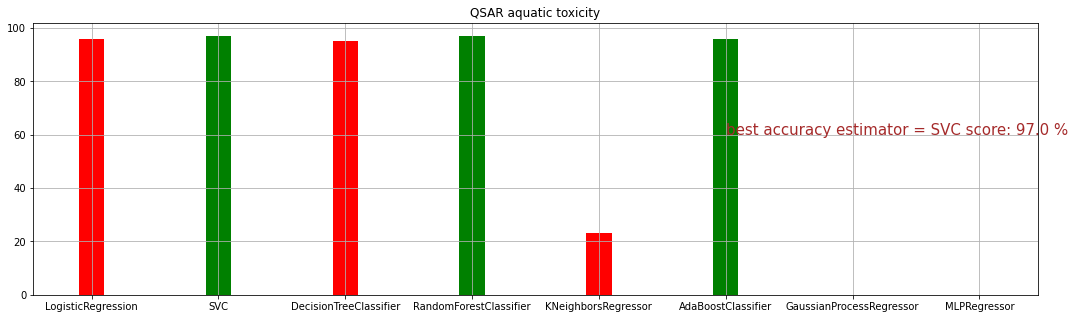

In [181]:
plotBarGraph(QSAR_scores, 'QSAR aquatic toxicity')

# ===================Dataset 4. Facebook======================

In [86]:
#importing the raw data

fbData = pd.read_csv('resources2/dataset_Facebook.csv',sep=';')

#we can see some of the rows have invalid data entries

#preprocessing the data
fbData.replace(r'^\s*$', np.nan, regex=True, inplace = True)
fbData.replace('?', np.nan, inplace = True)
#print(fbData.isnull().sum())

# as we are perdicting the total Intractions so we will not consider them 
unusefullFeatures = ['comment','like','share']
fbData = fbData.drop(columns= unusefullFeatures, axis=1)
fbData["Type"].value_counts()

# since datatype of "Type" is not interger, but we can make it integer by making four cloumns for each type ; link, photo, status, video
lb_style = LabelBinarizer()
lb_results = lb_style.fit_transform(fbData["Type"])
encoded_df = pd.DataFrame(lb_results, columns=lb_style.classes_)
fbData = pd.concat([fbData,encoded_df], axis=1) 
cols = list(fbData)
cols.insert(1, cols.pop(cols.index('Link')))
cols.insert(2, cols.pop(cols.index('Photo')))
cols.insert(3, cols.pop(cols.index('Status')))
cols.insert(4, cols.pop(cols.index('Video')))
fbData = fbData.loc[:, cols]
fbData = fbData.drop(columns=['Type'],axis=1)
#putting common values into the missing ones
fbData = fbData.apply(lambda x: x.fillna(x.value_counts().index[0]))
fbData.shape
(500, 19)

#Since almost every raw data has outliers so we need to remove them 
outlierThresholdValue = np.percentile(fbData['Total Interactions'],90)
fbData = fbData[fbData['Total Interactions'] < outlierThresholdValue]
fbData.shape

#Spliting the processed data into training and test datasets
#fbX_train, fbX_test, fby_train, fby_test = train_test_split(fbData.iloc[:, 0:18].values, fbData.iloc[:, 18].values, test_size=0.33, random_state=0)
#scaler = StandardScaler()
#scaler.fit(fbX_train)
#fbx_train_scaled = scaler.transform(fbX_train)
#fbx_test_scaled = scaler.transform(fbX_test)
fbData
X = fbData.drop('Total Interactions', axis='columns')
y = fbData['Total Interactions']

X_trn_facebook, X_tst_facebook, y_trn_facebook, y_tst_facebook = separateData(X,y)

fbData

,Page total likes,Link,Photo,Status,Video,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,Total Interactions
0,139441,0,1,0,0,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,100
1,139441,0,0,1,0,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,164
2,139441,0,1,0,0,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,80
4,139441,0,1,0,0,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,393
5,139441,0,0,1,0,2,12,1,9,0.0,10472,20849,1191,1073,1389,16034,7852,1016,186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,85093,0,1,0,0,3,1,7,2,0.0,4684,7536,733,708,985,4750,2876,392,84
496,81370,0,1,0,0,2,1,5,8,0.0,3480,6229,537,508,687,3961,2104,301,75
497,81370,0,1,0,0,1,1,5,2,0.0,3778,7216,625,572,795,4742,2388,363,115
498,81370,0,1,0,0,3,1,4,11,0.0,4156,7564,626,574,832,4534,2452,370,136


In [87]:
%%time
facebook_estimators, facebook_scores = train_with_all_classifier(X_trn_facebook, y_trn_facebook,
                                                                 'Facebook metrics', X_tst_facebook,y_tst_facebook)

Trainning LogisticRegression classifier model with  Facebook metrics data...
using LogisticRegression(max_iter=10, random_state=0)
testing accuracy using  LogisticRegression for data Facebook metrics 0.0 %

Trainning SVC classifier model with  Facebook metrics data...
using SVC(C=0.01, gamma=0.1, max_iter=10, random_state=0)
testing accuracy using  SVC for data Facebook metrics 0.0 %

Trainning DecisionTreeClassifier classifier model with  Facebook metrics data...
using DecisionTreeClassifier(max_depth=2, random_state=0)
testing accuracy using  DecisionTreeClassifier for data Facebook metrics 0.0 %

Trainning RandomForestClassifier classifier model with  Facebook metrics data...
using RandomForestClassifier(max_depth=4, n_estimators=200, random_state=0)
testing accuracy using  RandomForestClassifier for data Facebook metrics 1.0 %

Trainning KNeighborsRegressor classifier model with  Facebook metrics data...
using KNeighborsRegressor(algorithm='ball_tree', n_neighbors=10)
testing accur

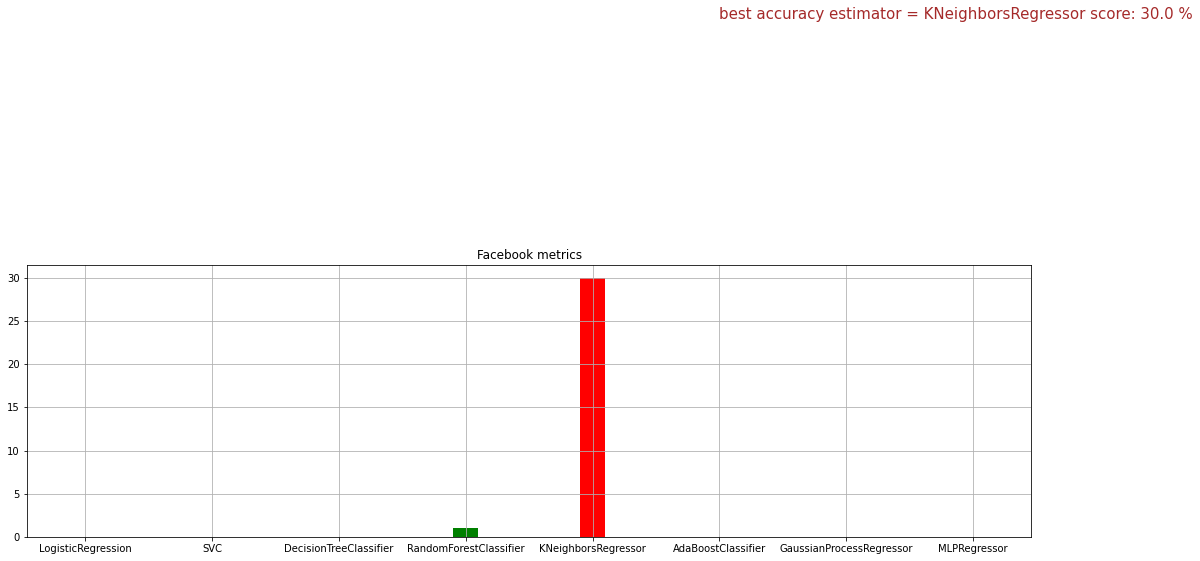

In [182]:
plotBarGraph(facebook_scores, 'Facebook metrics')

# =====================Dataset 5. Biking=======================
- To minimize training time, we are cutting the data to only 5000 data rather than 17000+

In [198]:
bikeHours = pd.read_csv('resources2/hour.csv')
X = bikeHours.drop('cnt', axis='columns')
y = bikeHours['cnt']

print('Before encoding')
display(bikeHours)

X['dteday'] = encoder.fit_transform(X['dteday'])
#X['temp'] = encoder.fit_transform(X['temp'])
#X['atemp'] = encoder.fit_transform(X['atemp'])
#X['windspeed'] = encoder.fit_transform(X['windspeed'])

X_trn_biking, X_tst_biking, y_trn_biking, y_tst_biking = separateData(X,y)

print('X: After encoding')
display(X)


Before encoding


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


X: After encoding


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered
0,1,0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13
1,2,0,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32
2,3,0,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27
3,4,0,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10
4,5,0,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,730,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108
17375,17376,730,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81
17376,17377,730,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83
17377,17378,730,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48


In [ ]:
%%time
biking_estimators, biking_scores = train_with_all_classifier(X_trn_biking, y_trn_biking,
                                                                 'Facebook metrics', X_tst_biking,y_tst_biking)

Training Linear regression model with  Facebook metrics dataset
testing accuracy using  LinearRegression for data Facebook metrics -107.0 %

Trainning SVR classifier model with  Facebook metrics data...
using SVR(gamma=0.1, max_iter=1)
testing accuracy using  SVR for data Facebook metrics -261.0 %

Trainning DecisionTreeRegressor classifier model with  Facebook metrics data...
using DecisionTreeRegressor(criterion='friedman_mse', max_depth=20)
testing accuracy using  DecisionTreeRegressor for data Facebook metrics 100.0 %

Trainning RandomForestRegressor classifier model with  Facebook metrics data...
using RandomForestRegressor(max_depth=4, n_estimators=200)
testing accuracy using  RandomForestRegressor for data Facebook metrics 98.0 %

Trainning KNeighborsRegressor classifier model with  Facebook metrics data...
using KNeighborsRegressor(algorithm='kd_tree')
testing accuracy using  KNeighborsRegressor for data Facebook metrics 96.0 %

Trainning AdaBoostRegressor classifier model with

Trainning LogisticRegression classifier model with  Bike Sharing data...
using LogisticRegression(max_iter=10, random_state=0)
testing accuracy using  LogisticRegression for data Bike Sharing 2.0 %



Trainning SVC classifier model with  Bike Sharing data...
using SVC(C=0.1, gamma=0.5, max_iter=10, random_state=0)
testing accuracy using  SVC for data Bike Sharing 2.0 %



Trainning DecisionTreeClassifier classifier model with  Bike Sharing data...
using DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=0)
testing accuracy using  DecisionTreeClassifier for data Bike Sharing 11.0 %



Trainning RandomForestClassifier classifier model with  Bike Sharing data...
using RandomForestClassifier(max_depth=10, n_estimators=400, random_state=0)
testing accuracy using  RandomForestClassifier for data Bike Sharing 8.0 %



Trainning KNeighborsRegressor classifier model with  Bike Sharing data...
using KNeighborsRegressor(algorithm='ball_tree')
testing accuracy using  KNeighborsRegressor for data Bike Sharing 96.0 %



Trainning AdaBoostClassifier classifier model with  Bike Sharing data...
using AdaBoostClassifier(n_estimators=400, random_state=0)
testing accuracy using  AdaBoostClassifier for data Bike Sharing 2.0 %



Trainning GaussianProcessRegressor classifier model with  Bike Sharing data...
using GaussianProcessRegressor(alpha=1e-09, n_restarts_optimizer=3, random_state=0)
testing accuracy using  GaussianProcessRegressor for data Bike Sharing 95.0 %



Trainning MLPRegressor classifier model with  Bike Sharing data...
using MLPRegressor(hidden_layer_sizes=10000, learning_rate='invscaling', max_iter=10,
             random_state=0)
testing accuracy using  MLPRegressor for data Bike Sharing 100.0 %

---------------------------------------------------


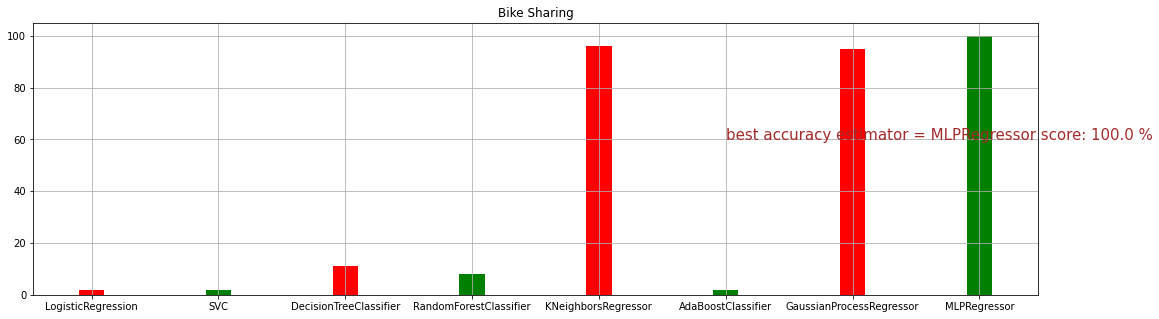

In [183]:
plotBarGraph(scores, 'Bike Sharing')

# ====================Dataset 6. Students=====================

In [128]:
studentPortMarks = pd.read_csv('resources2/student-por.csv',sep=';',  skipinitialspace=True)

print('Before encoding')
display(studentPortMarks)

X = studentPortMarks.drop('G3', axis='columns')
y = studentPortMarks['G3']

X['school'] = encoder.fit_transform(X['school'])
X['sex'] = encoder.fit_transform(X['sex'])
X['address'] = encoder.fit_transform(X['address'])
X['famsize'] = encoder.fit_transform(X['famsize'])
X['Pstatus'] = encoder.fit_transform(X['Pstatus'])
X['Mjob'] = encoder.fit_transform(X['Mjob'])
X['Fjob'] = encoder.fit_transform(X['Fjob'])
X['reason'] = encoder.fit_transform(X['reason'])
X['guardian'] = encoder.fit_transform(X['guardian'])
X['schoolsup'] = encoder.fit_transform(X['schoolsup'])
X['schoolsup'] = encoder.fit_transform(X['schoolsup'])
X['famsup'] = encoder.fit_transform(X['famsup'])
X['paid'] = encoder.fit_transform(X['paid'])
X['activities'] = encoder.fit_transform(X['activities'])
X['nursery'] = encoder.fit_transform(X['nursery'])
X['higher'] = encoder.fit_transform(X['higher'])
X['internet'] = encoder.fit_transform(X['internet'])
X['romantic'] = encoder.fit_transform(X['romantic'])


print('X: After encoding')
display(X)

X_trn_students, X_tst_students, y_trn_students, y_tst_students = separateData(X,y)



Before encoding


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,5,4,2,1,2,5,4,10,11,10
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,4,15,15,16
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,1,5,6,11,12,9
647,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,6,10,10,10


X: After encoding


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
0,0,0,18,1,0,0,4,4,0,4,...,0,4,3,4,1,1,3,4,0,11
1,0,0,17,1,0,1,1,1,0,2,...,0,5,3,3,1,1,3,2,9,11
2,0,0,15,1,1,1,1,1,0,2,...,0,4,3,2,2,3,3,6,12,13
3,0,0,15,1,0,1,4,2,1,3,...,1,3,2,2,1,1,5,0,14,14
4,0,0,16,1,0,1,3,3,2,2,...,0,4,3,2,1,2,5,0,11,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,1,0,19,0,0,1,2,3,3,2,...,0,5,4,2,1,2,5,4,10,11
645,1,0,18,1,1,1,3,1,4,3,...,0,4,3,4,1,1,1,4,15,15
646,1,0,18,1,0,1,1,1,2,2,...,0,1,1,1,1,1,5,6,11,12
647,1,1,17,1,1,1,3,1,3,3,...,0,2,4,5,3,4,2,6,10,10


In [129]:
%%time
students_estimators, students_scores = train_with_all_classifier(X_trn_students, y_trn_students,
                                                                 'Students', X_tst_students,y_tst_students)

Trainning LogisticRegression classifier model with  Students data...
using LogisticRegression(C=100, max_iter=10, random_state=0)
testing accuracy using  LogisticRegression for data Students 26.0 %

Trainning SVC classifier model with  Students data...
using SVC(gamma=0.1, max_iter=10, random_state=0)
testing accuracy using  SVC for data Students 18.0 %

Trainning DecisionTreeClassifier classifier model with  Students data...
using DecisionTreeClassifier(max_depth=6, random_state=0)
testing accuracy using  DecisionTreeClassifier for data Students 38.0 %

Trainning RandomForestClassifier classifier model with  Students data...
using RandomForestClassifier(max_depth=20, n_estimators=400, random_state=0)
testing accuracy using  RandomForestClassifier for data Students 40.0 %

Trainning KNeighborsRegressor classifier model with  Students data...
using KNeighborsRegressor(algorithm='kd_tree', n_neighbors=10)
testing accuracy using  KNeighborsRegressor for data Students 66.0 %

Trainning Ada

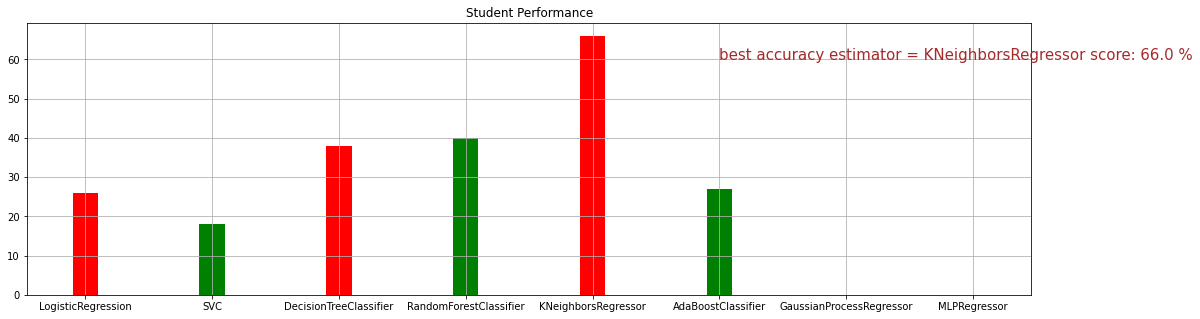

In [184]:
plotBarGraph(students_scores, 'Student Performance')

# ===========Dateset 7. Concrete Compressive Strength===========

- It is suggested to have a compressive strength for concrete below 50, so let us create estimators where output gives 1 when 
- the compressive strength for concrete is > 50

In [131]:
concreteData = pd.read_excel('resources2/Concrete_Data.xls')

X = concreteData.drop('Concrete compressive strength(MPa, megapascals) ', axis='columns')
y = concreteData['Concrete compressive strength(MPa, megapascals) ']

# encoding float numbers
X['Cement (component 1)(kg in a m^3 mixture)'] = encoder.fit_transform(X['Cement (component 1)(kg in a m^3 mixture)'])
X['Blast Furnace Slag (component 2)(kg in a m^3 mixture)'] = encoder.fit_transform(X['Blast Furnace Slag (component 2)(kg in a m^3 mixture)'])
X['Fly Ash (component 3)(kg in a m^3 mixture)'] = encoder.fit_transform(X['Fly Ash (component 3)(kg in a m^3 mixture)'])
X['Water  (component 4)(kg in a m^3 mixture)'] = encoder.fit_transform(X['Water  (component 4)(kg in a m^3 mixture)'])
X['Superplasticizer (component 5)(kg in a m^3 mixture)'] = encoder.fit_transform(X['Superplasticizer (component 5)(kg in a m^3 mixture)'])
X['Coarse Aggregate  (component 6)(kg in a m^3 mixture)'] = encoder.fit_transform(X['Coarse Aggregate  (component 6)(kg in a m^3 mixture)'])
X['Fine Aggregate (component 7)(kg in a m^3 mixture)'] = encoder.fit_transform(X['Fine Aggregate (component 7)(kg in a m^3 mixture)'])
y = y.astype('uint8')
X_trn_concrete, X_tst_concrete, y_trn_concrete, y_tst_concrete = separateData(X,y)
print('Before encoding')
display(concreteData)
print('After encoding')
display(X)


Before encoding


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


After encoding


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
0,279,0,0,44,5,221,37,28
1,279,0,0,44,5,235,37,28
2,222,88,0,200,0,110,0,270
3,222,88,0,200,0,110,0,365
4,96,73,0,152,0,170,237,360
...,...,...,...,...,...,...,...,...
1025,160,53,26,106,73,55,146,28
1026,213,0,68,166,95,6,223,28
1027,35,84,58,153,32,73,166,28
1028,62,140,0,92,108,177,185,28


In [132]:
%%time
concrete_estimators, concrete_scores = train_with_all_classifier(X_trn_concrete, y_trn_concrete,
                                                                 'Concrete Compressive Strength', X_tst_concrete, y_tst_concrete)

Trainning LogisticRegression classifier model with  Concrete Compressive Strength data...
using LogisticRegression(C=10.0, max_iter=10, random_state=0)
testing accuracy using  LogisticRegression for data Concrete Compressive Strength 7.000000000000001 %

Trainning SVC classifier model with  Concrete Compressive Strength data...
using SVC(gamma=2.0, max_iter=10, random_state=0)
testing accuracy using  SVC for data Concrete Compressive Strength 17.0 %

Trainning DecisionTreeClassifier classifier model with  Concrete Compressive Strength data...
using DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=0)
testing accuracy using  DecisionTreeClassifier for data Concrete Compressive Strength 16.0 %

Trainning RandomForestClassifier classifier model with  Concrete Compressive Strength data...
using RandomForestClassifier(max_depth=20, n_estimators=200, random_state=0)
testing accuracy using  RandomForestClassifier for data Concrete Compressive Strength 20.0 %

Trainning KN

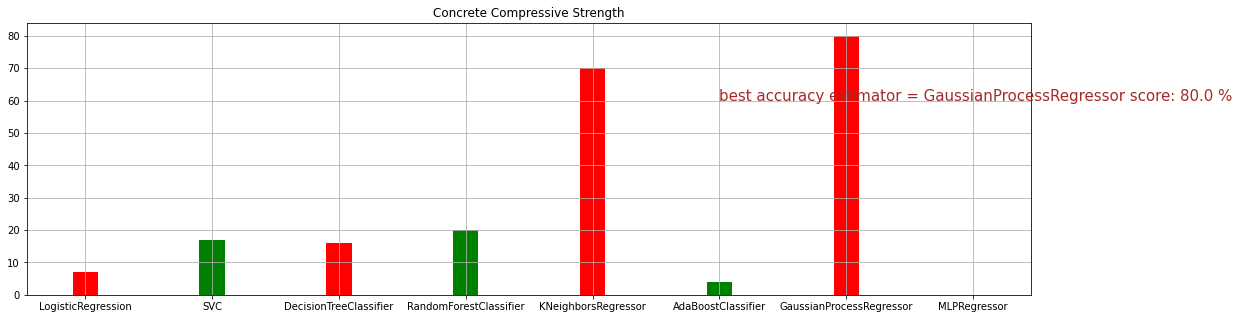

In [185]:
plotBarGraph(concrete_scores, 'Concrete Compressive Strength')

# ===================Dateset 8. GPU =================== 

In [150]:
#extracting data
gpuData = pd.read_csv("resources2/sgemm_product.csv")
display(gpuData)
#checking null values
#print(gpuData.isnull().sum())
#Preparing the the dataset
X = gpuData[gpuData.columns[:-4]] 
y = (gpuData['Run1 (ms)']+gpuData['Run2 (ms)']+gpuData['Run3 (ms)']+gpuData['Run4 (ms)'])/4


#splitting the data into training and testing datasets
y = encoder.fit_transform(y)
X = X.astype('uint8')
y = y.astype('uint8')
X_trn_GPU, X_tst_GPU, y_trn_GPU, y_tst_GPU = separateData(X,y)

print('averaging the 4 different runs and use it as y- output data')
# only using 10000 data from all the existing data to maximize running time
X_trn_GPU = X_trn_GPU.iloc[0:10000,:]
y_trn_GPU = y_trn_GPU[0:10000]
X_tst_GPU = X_tst_GPU.iloc[0:2000,:]
y_tst_GPU = y_tst_GPU[0:2000]


,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241595,128,128,32,32,32,32,32,8,4,4,1,0,1,1,17.96,17.77,17.77,17.77
241596,128,128,32,32,32,32,32,8,4,4,1,1,0,0,36.04,36.03,36.04,36.03
241597,128,128,32,32,32,32,32,8,4,4,1,1,0,1,35.28,34.82,35.27,35.27
241598,128,128,32,32,32,32,32,8,4,4,1,1,1,0,28.43,28.49,28.44,28.45


averaging the 4 different runs and use it as y- output data


In [151]:
%%time
GPU_estimators, GPU_scores = train_with_all_classifier(X_trn_GPU, y_trn_GPU,
                                                                 'GPU', X_tst_GPU, y_tst_GPU)

Trainning LogisticRegression classifier model with  GPU data...
using LogisticRegression(C=0.1, max_iter=10, random_state=0)
testing accuracy using  LogisticRegression for data GPU 0.0 %

Trainning SVC classifier model with  GPU data...
using SVC(gamma=0.1, max_iter=10, random_state=0)
testing accuracy using  SVC for data GPU 1.0 %

Trainning DecisionTreeClassifier classifier model with  GPU data...
using DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=0)
testing accuracy using  DecisionTreeClassifier for data GPU 0.0 %

Trainning RandomForestClassifier classifier model with  GPU data...
using RandomForestClassifier(max_depth=2, n_estimators=50, random_state=0)
testing accuracy using  RandomForestClassifier for data GPU 1.0 %

Trainning KNeighborsRegressor classifier model with  GPU data...
using KNeighborsRegressor(n_neighbors=20)
testing accuracy using  KNeighborsRegressor for data GPU -5.0 %

Trainning AdaBoostClassifier classifier model with  GPU data...
using

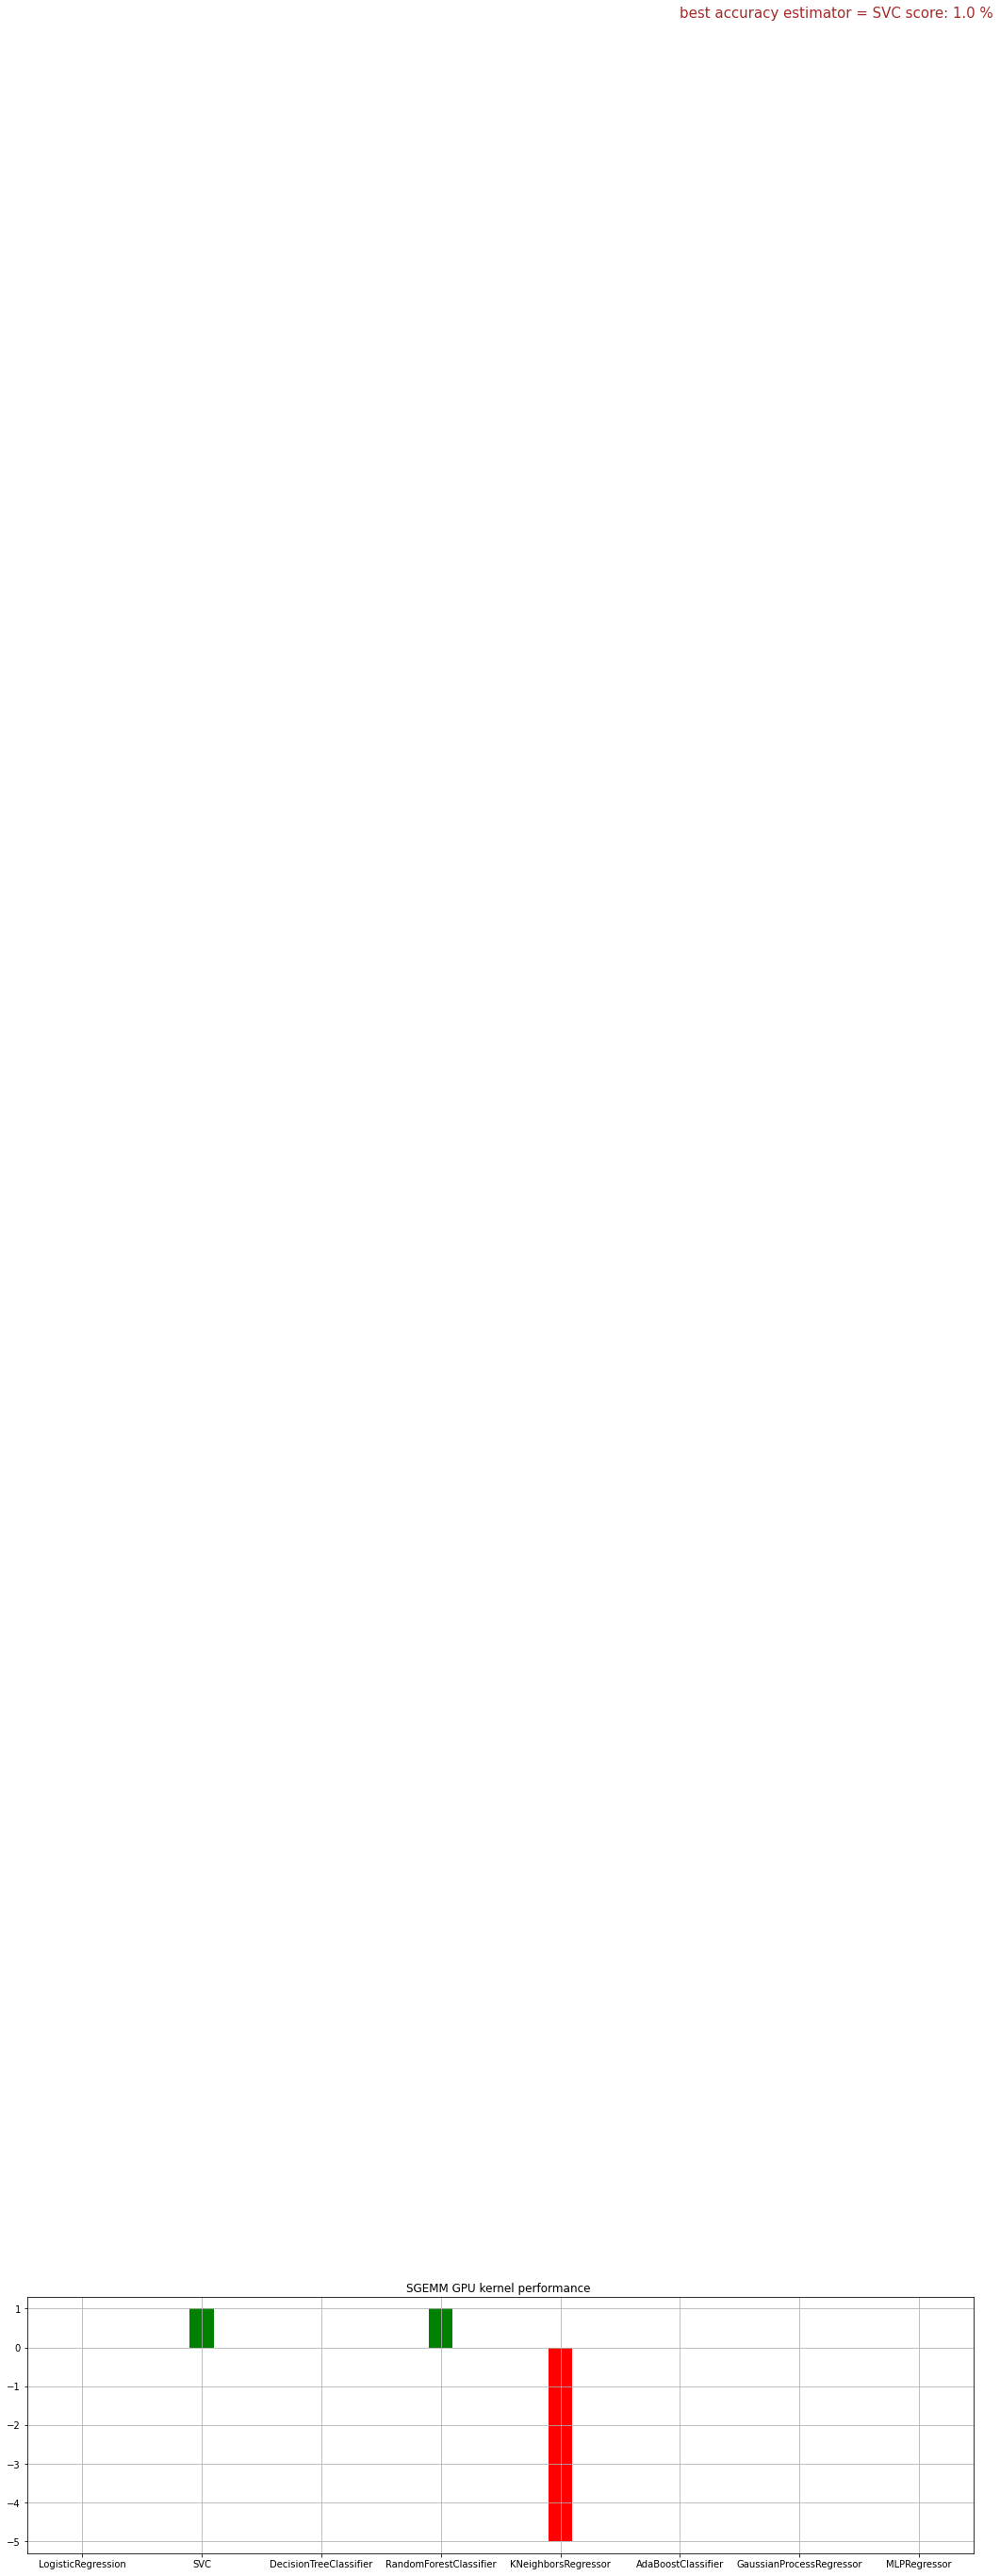

In [188]:
plotBarGraph(GPU_scores, 'SGEMM GPU kernel performance ')